In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd


import matplotlib.dates as md
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns

sns.set()

### Visualization Functions

The following functions will be used throughout this notebook to visualize the data for each of the sensors.

In [3]:
def plotHistogram(df, column, title):
    """Plot a histogram of the sensor data."""
    
    # Calculate number of hist bins
    n_data = len(df[column])
    n_bins = int(np.sqrt(n_data))
    
    fig, ax = plt.subplots()
    
    ax.hist(
        df[column], bins=n_bins,
        range=(df[column].min(), df[column].max())
    )
    
    # Set the plot title
    ax.set_title(title, size=18)
    
    # Set the ylabel
    ax.set_ylabel('Count')
    
    # Set the x-ticks and y-ticks parameters
    ax.xaxis.set_major_formatter(
        tkr.FuncFormatter(lambda x,  p: format(int(x), ','))
    )
    ax.yaxis.set_major_formatter(
        tkr.FuncFormatter(lambda y,  p: format(int(y), ','))
    )
    
    # Show plot
    plt.show()

## Import & Clean Sensor Data

As a student in Georgetown University's Data Science Certificate Program, I worked with four other students on a semester long Capstone project that used Raspberry Pi 3 and other devices to capture sensor data from our classroom. My primary role on the team involved cleaning the data and building the machine learning models.

In this notebook I'll ingest the data and clean each sensor separately, since this will make it easier to explore the data and to identify potential outliers. Once I'm finished, I will concatenate the individual DataFrames and backfill any missing data.

## Data Ingestion

The `sensor_data.csv` file contains 46,275 observations and contains the following features: location, location_CO2, temperature, humidity, sound, bluetooth devices, and non-personal bluetooth devices.

In [4]:
# Read csv file in as a Pandas DataFrame with a DateTimeIndex: df
df = pd.read_csv('../data/sensor_data.csv', index_col='datetime', parse_dates=True)

# Rename the columns
df.columns = [
    'loc', 'loc2', 'temperature', 'humidity', 'co2', 'light', 'sound', 'bluetooth', 'nonpersonal_bluetooth'
]

When the project first began, our team had debated the idea of gathering data from other classrooms, which is why this dataset contains two location columns. However, since it only contains data from our classroom, I can drop these columns.

In [5]:
# Delete the two location columns
df.drop(['loc', 'loc2'], axis=1, inplace=True)

### Dataset Overview

Grouping by day shows that we have data for 11 class periods. Each day has a different number of values, since it wasn't possible to begin and end recording at the exact time each day. In addition, Friday night classes were only 3 hours long, from 6:30 PM to 9:30 PM EST, while Saturday classes were 7&#189; hours, from 9:00 AM to 4:30 PM EST. This is why there are significantly fewer observations on May 5th, May 12th, and June 3rd. 

We can also see that we're missing data for `nonpersonal_bluetooth` for the first two classes, which we will need to deal with later because scikit-learn cannot handle missing values.

In [6]:
# Use groupby to see which days are captured in the data
df.groupby(df.index.strftime('%D')).count()

,temperature,humidity,co2,light,sound,bluetooth,nonpersonal_bluetooth
03/25/17,3711,3711,3711,3711,3711,3711,0
04/01/17,4377,4377,4377,4377,4377,4377,0
04/08/17,4575,4575,4575,4575,4575,4575,4575
04/22/17,5298,5298,5298,5298,5298,5298,5298
04/29/17,5039,5039,5039,5039,5039,5039,5039
05/05/17,2390,2390,2390,2390,2390,2390,2390
05/06/17,5320,5320,5320,5320,5320,5320,5320
05/12/17,2083,2083,2083,2083,2083,2083,2083
05/13/17,5195,5195,5195,5195,5195,5195,5195
06/03/17,2745,2745,2745,2745,2745,2745,2745


## Data Wrangling

The initial exploratory data analysis showed that the several of the sensors had generated multiple error values. Most often, these readings occurred at the beginning and end of the day when the devices were turned on and off. However, there were also cases when the sensors would restart, causing either error values and creating gaps of missing data.

Some of the error values were easy to identify, such as a temperature reading of -999.99 °Celsius. However others, such as a CO&#8322; value of 2, required further investigation, since without any domain knowledge, I couldn’t be certain if 2 was a low, but accurate reading.

### Temperature Data

    Type of Sensor: AM2303 (captures both temperature and humidity)  
    Sensor Range: -40 to 125°C

    Reference: OSHA recommends temperature control in the range of 20-24.4°C (68-76°F). 

In [7]:
# Create temperature dataframe with a DateTimeIndex
temperature_data = df[['temperature']].copy()

The temperature data has two -999 values. Below, we can see that on April 8th it was the first value of the day, while the second occurred on May 6th during the first hour of class. In addition, because the AM2303 sensor captures both temperature and relative humidity, these same -999 errors allow show up in the humidity data.

In [8]:
# Summary statistics for the temperature data
temperature_data.describe()

,temperature
count,46275.000000
mean,23.022280
std,6.845733
min,-999.000000
25%,22.400000
50%,22.900000
75%,23.200000
max,29.400000


In [9]:
# Show when the first -999 value was recorded
temperature_data['2017-04-08'].head()

,temperature
datetime,
2017-04-08 08:58:39,-999.0
2017-04-08 08:58:44,21.8
2017-04-08 08:58:50,21.8
2017-04-08 08:58:55,21.8
2017-04-08 08:59:00,21.8


In [10]:
# Show when the second -999 temperature value was recorded
temperature_data['2017-05-06 09:22:05':'2017-05-06 09:22:20']

,temperature
datetime,
2017-05-06 09:22:06,23.2
2017-05-06 09:22:11,23.1
2017-05-06 09:22:12,-999.0
2017-05-06 09:22:16,23.1
2017-05-06 09:22:17,22.7


Since even Neptune, the coldest planet in our solar system (sorry Pluto!), has an average temperature of -214°C, the -999 values are obviously errors generated by the sensor, so I'll delete them. 

In [11]:
# Delete two -999 values
temperature_data = temperature_data[temperature_data['temperature'] != -999]

In [12]:
# Updated summary statistics for the temperature data
temperature_data.describe()

,temperature
count,46273.000000
mean,23.066453
std,1.310251
min,20.700000
25%,22.400000
50%,22.900000
75%,23.200000
max,29.400000


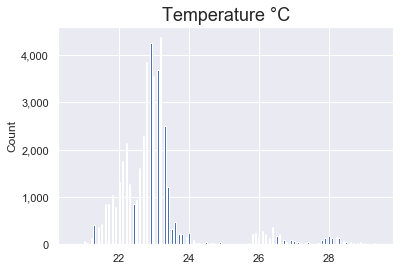

In [13]:
# Plot a histogram of the temperature data
plotHistogram(temperature_data, 'temperature', 'Temperature °C')

### Humidity

    Type of Sensor: AM2303
    Sensor Range: 0-100% RH

    Reference: OSHA recommends humidity control in the range of 20%-60%.

In [14]:
# Create humidity dataframe with DateTimeIndex: humidity_data
humidity_data = df[['humidity']].copy()

Our sensor captured both temperature and humidity together, which is why the humidity data also contains two -999 values.

In [15]:
# Summary statistics for the humidity data
humidity_data.describe()

,humidity
count,46275.000000
mean,39.769657
std,9.471097
min,-999.000000
25%,37.800000
50%,40.100000
75%,45.100000
max,52.200000


In [16]:
# Delete two -999 values
humidity_data = humidity_data[humidity_data['humidity'] != -999]

In [17]:
# Updated humidity statistics
humidity_data.describe()

,humidity
count,46273.000000
mean,39.814555
std,6.562350
min,20.800000
25%,37.800000
50%,40.100000
75%,45.100000
max,52.200000


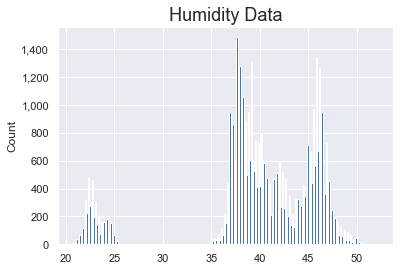

In [18]:
# Plot a histogram of the humidity data
plotHistogram(humidity_data, 'humidity', 'Humidity Data')

### CO&#8322; Data

    Type of Sensor: COZIR Ambient GC-0010 Sensor
    Sensor Range: 0-2000 parts per million (ppm)

    Reference: OSHA recommends keeping indoor CO&#8322; levels below 1000 ppm.   

In [19]:
# Create CO2 dataframe with DateTimeIndex: co2_data
co2_data = df[['co2']].copy()

The summary statistics report a mean of 1236.25 and a standard deviation of 178.46. However, the 25% quartile has a range of 2 to 1110. 

While the -999 temperature and humidity values were obviously errors, without any domain knowledge, I didn't initially know if a CO&#8322; value of 2 was caused by a sensor error or was a low, but accurate, reading. 

In [20]:
# Summary statistics for the CO2 data
co2_data.describe()

,co2
count,46275.00000
mean,1236.24510
std,178.36047
min,2.00000
25%,1110.00000
50%,1261.00000
75%,1355.00000
max,2001.00000


The sensor randomly generated thirty-three error 2 values, and while they did not only occur when the sensor was turned on, they did also occur at that time.

In [21]:
# Identify how many 2 values are in the data
len(co2_data[co2_data['co2'] == 2])

33

In [22]:
# Look at the first CO2 value from April 8, 2017
co2_data.loc['2017-04-08'].head()

,co2
datetime,
2017-04-08 08:58:39,2.0
2017-04-08 08:58:44,792.0
2017-04-08 08:58:50,776.0
2017-04-08 08:58:55,763.0
2017-04-08 08:59:00,776.0


In [23]:
# Look at the first CO2 value from June 10, 2017
co2_data.loc['2017-06-10'].head()

,co2
datetime,
2017-06-10 09:03:10,2.0
2017-06-10 09:03:15,1290.0
2017-06-10 09:03:20,1310.0
2017-06-10 09:03:25,1293.0
2017-06-10 09:03:30,1333.0


In [24]:
# Delete 2 values
co2_data = co2_data[co2_data['co2'] != 2]

In [25]:
# Updated CO2 statistics
co2_data.describe()

,co2
count,46242.000000
mean,1237.125903
std,175.348893
min,629.000000
25%,1110.000000
50%,1261.000000
75%,1355.000000
max,2001.000000


On April 1, 2017, the CO&#8322; sensor readings suddenly spiked up to 2001, as you can see below. The sensor was only supposed to have a range of 0-2000 ppm.

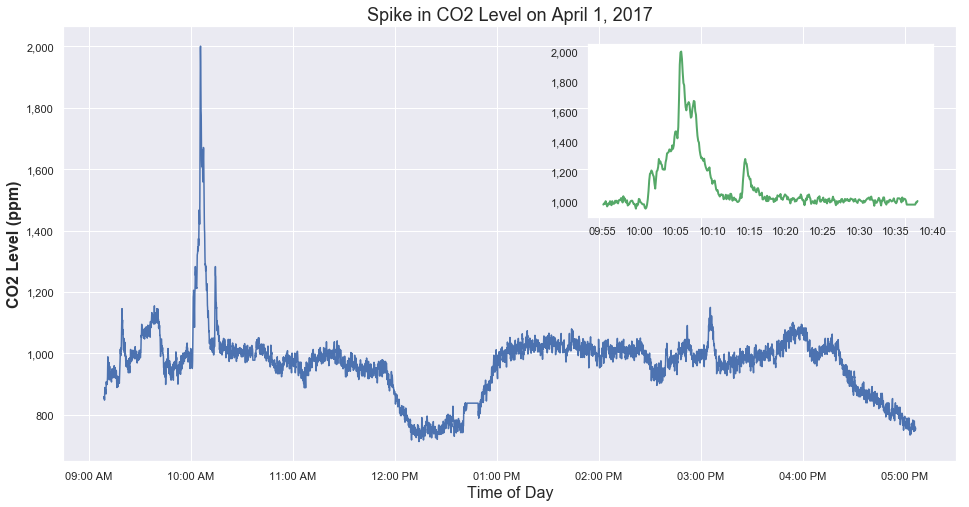

In [26]:
# Plot spike in CO2 level on April 1, 2017
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(co2_data.loc['April 1, 2017'])
ax.set_title('Spike in CO2 Level on April 1, 2017', fontsize=18)
ax.set_ylabel('CO2 Level (ppm)', fontsize=16, weight='bold')
ax.set_xlabel('Time of Day', fontsize=16)
ax.xaxis.set_major_formatter(md.DateFormatter('%I:%M %p'))
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))

ax = plt.axes([.58, .55, .3, .3], facecolor='w')
ax.plot(co2_data['co2'].loc['2017-04-01 09:55:00':'2017-04-01 10:38:00'].index, 
        co2_data['co2'].loc['2017-04-01 09:55:00':'2017-04-01 10:38:00'], 'g', linewidth=2.0)
ax.xaxis.set_major_formatter(md.DateFormatter('%I:%M'))
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))
plt.show()

To remove the error values caused by the spike, I decided to delete the values above 1628. I choose that value by looking at the max value for the other days, since they did not have any spikes, and the highest value was 1628 on June 10th. 

In [27]:
# Delete error CO2 values above 1628
co2_data = co2_data[co2_data['co2'] <= 1628]

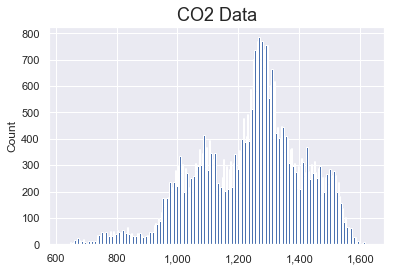

In [28]:
# Plot a histogram of the updated CO2 data
plotHistogram(co2_data, 'co2', 'CO2 Data')

### Sound Data

    Type of Sensor: Electret Microphone Amplifier MAX4466  
    Sensor Range: 0 to 20K Hz

    Reference: Human speech frequencies are in the range of 500 Hz to 4,000 Hz. A young person with normal hearing can hear frequencies between approximately 20 Hz and 20,000 Hz. 

In [29]:
# Create noise dataframe with DateTimeIndex: sound_data
sound_data = df[['sound']].copy()

In [30]:
# Summary statistics for the sound data
sound_data.describe()

,sound
count,46275.000000
mean,283.936704
std,174.322552
min,0.000000
25%,144.000000
50%,145.000000
75%,495.000000
max,1023.000000


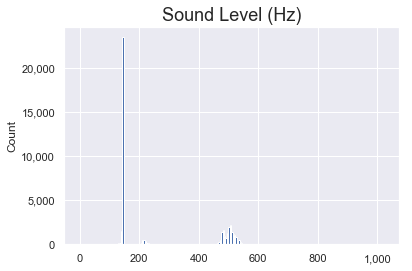

In [31]:
# Plot a histogram of the sound data
plotHistogram(sound_data, 'sound', 'Sound Level (Hz)')

### Light Data

    Type of Sensor: Photoresistor GL5537

    Reference: Illuminance is measured in foot candles or lux (in the metric SI system). GSA recommends a nominal illumination level (Lumens/Square Meter lux) of 300 for conference rooms, or 500 Lux in work station space, open and closed offices, and in training rooms.

    For Reference: The sensor has a light resistance of 10 Lux (30 to 50 kohm).

In [32]:
# Create light dataframe with DateTimeIndex: light_data
light_data = df[['light']].copy()

In [33]:
# Summary statistics for the light data
light_data.describe()

,light
count,4.627500e+04
mean,2.923096e+03
std,1.494275e+05
min,0.000000e+00
25%,1.780000e+02
50%,2.070000e+02
75%,3.830000e+02
max,1.000000e+07


In [34]:
# Identify the high error values
light_max = light_data[light_data['light'] > 4000]
light_max['light']

datetime
2017-04-08 14:02:54    9306527.000
2017-04-22 11:56:44    7718174.000
2017-04-22 12:53:51    8308485.000
2017-04-22 14:10:58    8016883.000
2017-04-29 12:23:45    9999999.999
2017-04-29 14:33:24    9999999.999
2017-04-29 15:57:55    9999999.999
2017-04-29 16:03:05       4042.000
2017-04-29 16:03:10       4052.000
2017-05-06 11:13:38    8009105.000
2017-05-12 18:26:26    8707175.000
2017-05-12 20:46:56    8725352.000
2017-05-13 09:02:19    9135322.000
2017-06-10 10:57:31    8281044.000
2017-06-10 12:30:24    9273526.000
Name: light, dtype: float64

While a light value of 0 is possible, it's unlikely since even with the classroom lights turned off, there still would have been light from the hallway. In addition, I concluded that these 0 values were errors since they were isolated readings, as can be seen below.

In [35]:
# Look at 0 light reading on March 25, 2017
light_data.light['March 25, 2017 11:48:20':'March 25, 2017 11:49:00']

datetime
2017-03-25 11:48:22    463.0
2017-03-25 11:48:28    454.0
2017-03-25 11:48:34    465.0
2017-03-25 11:48:40      0.0
2017-03-25 11:48:46    462.0
2017-03-25 11:48:52    461.0
2017-03-25 11:48:58    445.0
Name: light, dtype: float64

In [36]:
# Identify how many 0 light values are in the data
len(light_data[light_data['light'] == 0])

12

In [37]:
# Delete error 0 light values
light_data = light_data[light_data['light'] != 0]

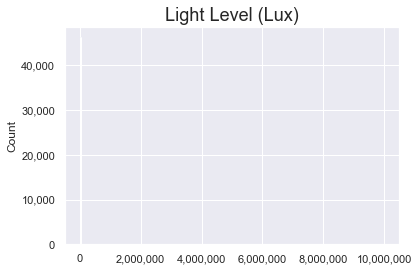

In [38]:
# Plot updated histogram of light data
plotHistogram(light_data, 'light', 'Light Level (Lux)')

### Bluetooth Devices

In [39]:
# Create bluetooth devices dataframe with DateTimeIndex: bluetooth_data
bluetooth_data = df[['bluetooth']].copy()

The minimum for the `bluetooth` is 0 columns also seems suspicous, since the students setting up the sensors had devices emitting bluetooth signals. Later we'll also examine the large range of values in the light column. In addition, similar to other error values generated by the sensors, the first value of the day seems to be incorrect.

In [40]:
# Summary statistics for the bluetooth data
bluetooth_data.describe()

,bluetooth
count,46275.00000
mean,220.83369
std,140.24883
min,0.00000
25%,116.00000
50%,181.00000
75%,309.00000
max,635.00000


In [41]:
# Plot the bluetooth data for May 5, 2017
bluetooth_data['bluetooth']['May 5, 2017'].head()

datetime
2017-05-05 18:13:53     0
2017-05-05 18:13:58    30
2017-05-05 18:14:03    31
2017-05-05 18:14:08    31
2017-05-05 18:14:13    32
Name: bluetooth, dtype: int64

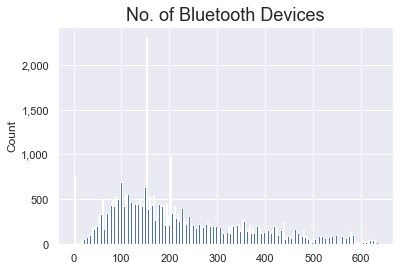

In [42]:
# Plot a histogram of the bluetooth data
plotHistogram(bluetooth_data, 'bluetooth', 'No. of Bluetooth Devices')

### Non-Personal Bluetooth Data

Besides missing data from March 25th and April 1st, the non-personal bluetooth data also contains a large number of 0 values. 

In [43]:
# Create non-personal bluetooth devices dataframe with DateTimeIndex
bluetooth_np_data = df[['nonpersonal_bluetooth']].copy()

In [44]:
# Identify the number of 0 values
len(bluetooth_np_data[bluetooth_np_data['nonpersonal_bluetooth'] == 0])

768

In [45]:
# Slice bluetooth_devices and bluetooth_non_personal_devices columns into a new dataframe: bluetooth_combined
bluetooth_combined = df.loc['April 8, 2017', 'bluetooth':'nonpersonal_bluetooth']

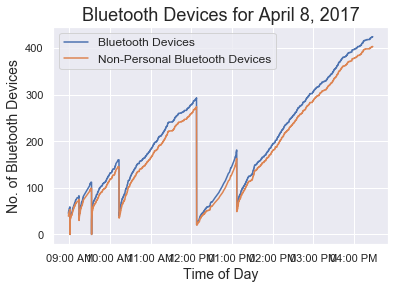

In [46]:
# Plot bluetooth devices and non-personal devices for April 8, 2017
fig, ax = plt.subplots()

ax.plot(bluetooth_combined)
ax.set_title('Bluetooth Devices for April 8, 2017', size=18)
ax.set_xlabel('Time of Day', fontsize=14)
ax.xaxis.set_major_formatter(md.DateFormatter('%I:%M %p'))
ax.set_ylabel('No. of Bluetooth Devices', fontsize=14)
ax.legend(('Bluetooth Devices', 'Non-Personal Bluetooth Devices'), loc='upper left', fontsize=12)
plt.show()

In [47]:
# ToDo: fix formatting on previous chart's x-ticks

## Concatenate the Data

In [ ]:
# ToDo: concatenate the individual DataFrames

### Save Data

In [ ]:
# Export updated sensor data to a CSV file: ml_sensor_data.csv
sensor_data.to_csv('..data/ml_sensor_data.csv')